# Unfolding

In [1]:
import countingworkspace
from countingworkspace import create_workspace
import countingworkspace.utils
import ROOT

import numpy as np
from scipy import stats
from scipy.optimize import nnls
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

countingworkspace.utils.silence_roofit()

Welcome to JupyROOT 6.14/08


## Methods

Assume to know the folding matrix perfectly ($M$). Observe $\{x\}_R$, want to unfold to the true distribution $\{y\}_T$.

   * Matrix inversion with likelihood. Maximize likelihood
   $$\prod_R \text{Poisson}\left(x_R|\sum_T M_{RT}y_T \right)$$
   * Matrix inversion with likelihood, requiring positive solution. Same likelihood as before
   * Matrix inversion with least squares. Minimize
   $$\sum_R \left(x_R - \sum_{T} M_{RT} y_T\right)^2$$
   implemented with [numpy.linalg.lstsq.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)
   * Matrix inversion with least squares positive contrains. Minimize same quantity as before
   Implemented with [scipy.optimize.nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html)
   * bin-by-bin correction factor with likelihood. Maximize likelihood
   $$\prod_R \text{Poisson}\left(x_R|C_T y_T \right)$$
   * bin-by-bin correction factor with simple division:
   $$y_i = x_i / C_i$$

## Definitions about the binnings

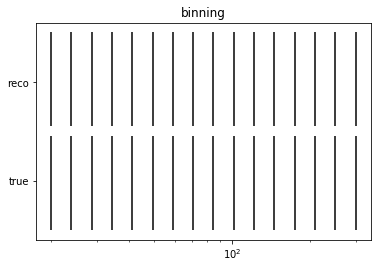

In [2]:
XMIN = 20
XMAX = 300
NBINS_TRUE = 15

xtrue_edges = np.logspace(np.log10(XMIN), np.log10(XMAX), NBINS_TRUE + 1)
xtrue_centers = 0.5 * (xtrue_edges[1:] + xtrue_edges[:-1])
xtrue_widths = np.diff(xtrue_edges)

# in principle you can play and use different binning, but only for the matrix method
#xreco_edges = np.logspace(np.log10(XMIN), np.log10(XMAX), 2 * NBINS_TRUE + 1)
xreco_edges = np.logspace(np.log10(XMIN), np.log10(XMAX), NBINS_TRUE + 1)
xreco_centers = 0.5 * (xreco_edges[1:] + xreco_edges[:-1])
xreco_widths = np.diff(xreco_edges)

NBINS_RECO = len(xreco_edges) - 1

fig, ax = plt.subplots()
ax.vlines(xtrue_edges, 0, 0.95)
ax.vlines(xreco_edges, 1.05, 2)
ax.set_xscale('log')

ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(['true', 'reco'])
ax.set_title('binning')

plt.show()

## True distribution

In [3]:
NTRUE = 10000  # number of events expected at truth-level, in the whole range
true_pdf = stats.expon(scale=60)

# number of counting for each bin, at truth level
ntrue = np.diff(true_pdf.cdf(xtrue_edges))

In [4]:
# ntrue is normalized to 1 in the whole space, not in the binned one (missing under/over-flow)
print(ntrue.sum())

0.7097933635747037


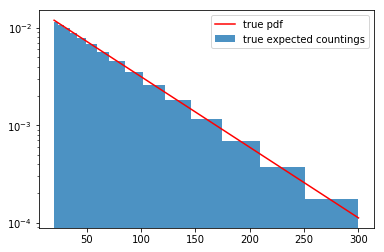

In [5]:
x = np.linspace(XMIN, XMAX, 200)

fig, ax = plt.subplots()

ax.plot(x, (true_pdf.pdf(x)), 'r', label='true pdf')
ax.bar(xtrue_edges[:-1], ntrue / xtrue_widths, width=xtrue_widths, align='edge', alpha=0.8, label='true expected countings')
ax.legend()
ax.set_yscale('log')
plt.show()

## Resolution model

Text(0, 0.5, 'relative bias')

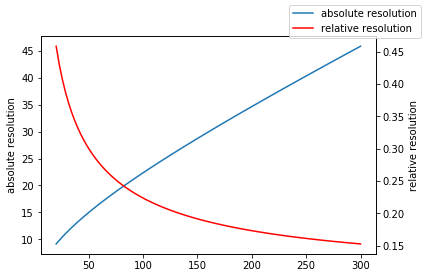

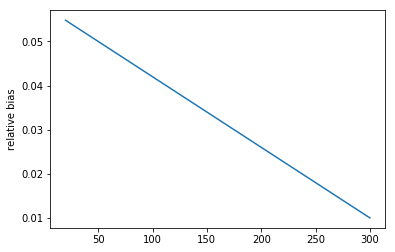

In [6]:
def qsum(x):
    """
    quadratic sum of the element in the list
    """
    x = np.asarray(x)
    return np.sqrt(np.sum(x ** 2))


# absolute resolution
def get_resolution(xtrue):
    return qsum([2. / np.sqrt(xtrue), 0.1])  * xtrue  # random numbers, bad resolution


# absolute bias
def get_bias(xtrue):
    return (0.05 - 0.00016 * (xtrue - 50)) * xtrue


def get_resolution_model():
    def f(xtrue):
        return stats.norm(get_bias(xtrue), get_resolution(xtrue))
    return f

x = np.linspace(XMIN, XMAX, 100)

fig, ax = plt.subplots()

ax.plot(x, get_resolution(x), label='absolute resolution')
ax.set_ylabel('absolute resolution')
ax2 = ax.twinx()
ax2.plot(x, get_resolution(x) / x, 'r', label='relative resolution')
ax2.set_ylabel('relative resolution')
fig.legend()

fig, ax = plt.subplots()

ax.plot(x, get_bias(x) / x)
ax.set_ylabel('relative bias')

## Efficiency model

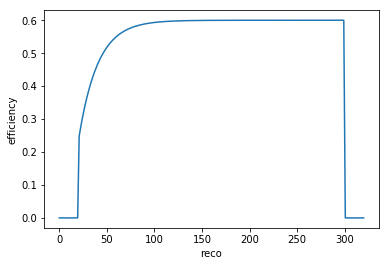

In [7]:
# we cut on reco-quantity, so define it as a function of xreco
def get_efficiency(xreco):
    return np.where((xreco < XMIN) | (xreco > XMAX), 0, 0.60 - np.exp(-xreco / 20.))

x = np.linspace(XMIN - 20, XMAX + 20, 200)
efficiency = get_efficiency(x)
fig, ax = plt.subplots()
ax.plot(x, efficiency)
ax.set_ylabel('efficiency')
ax.set_xlabel('reco')
plt.show()

In [8]:
# this is the equivalent of a full MC simulation, events are generated one by one

def create_toy(nevents, true_pdf, resolution_model, efficiency_model, randomize_nevents=False):
    if randomize_nevents:
        nevents = np.random.poisson(nevents)
    # not very efficiency: a lot of events generated far from the selected region
    toy_true_xvalues = true_pdf.rvs(nevents)
    smearing = resolution_model(toy_true_xvalues).rvs(nevents)
    
    toy_reco_xvalues = toy_true_xvalues + smearing
    toy_ispass = stats.bernoulli(efficiency_model(toy_reco_xvalues)).rvs(nevents).astype(bool)

    toy_reco_xvalues = np.where(toy_ispass, toy_reco_xvalues, np.nan)
    return toy_true_xvalues, toy_reco_xvalues, toy_ispass

In [9]:
# time to create 1M toys
%timeit create_toy(1000000, true_pdf, get_resolution_model(), get_efficiency)

170 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Generate the folding matrix using a huge MC

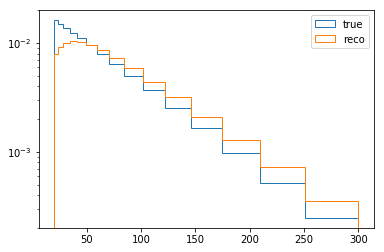

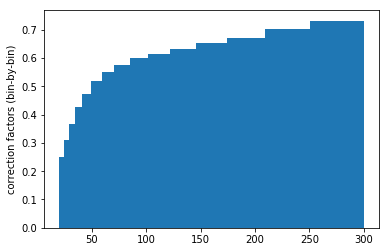

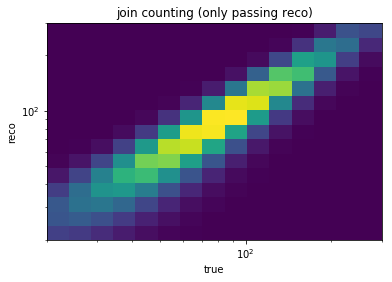

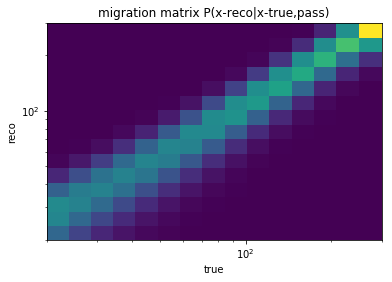

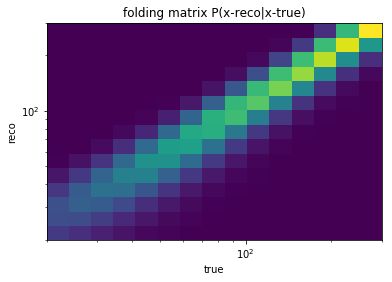

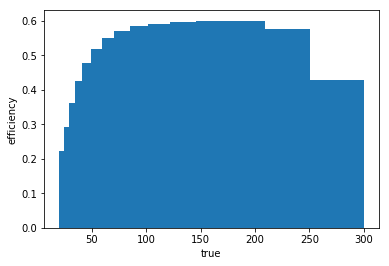

In [10]:
toy_true_xvalues, toy_reco_xvalues, toy_ispass = create_toy(4000000, true_pdf, get_resolution_model(), get_efficiency)
h_join, _, _ = np.histogram2d(toy_reco_xvalues[toy_ispass], toy_true_xvalues[toy_ispass], bins=[xreco_edges, xtrue_edges])
migration_matrix = (h_join / h_join.sum(axis=0))
h_true, _ = np.histogram(toy_true_xvalues, bins=xtrue_edges)
h_reco_true_bins, _ = np.histogram(toy_reco_xvalues, bins=xtrue_edges)  # for bin-by-bin unfolding
cfactors = h_reco_true_bins / h_true
folding_matrix = h_join / h_true

fig, ax = plt.subplots()
ax.hist(toy_true_xvalues, bins=xtrue_edges, histtype='step', density=True, label='true')
ax.hist(toy_reco_xvalues, bins=xreco_edges, histtype='step', density=True, label='reco')
ax.legend()
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.bar(xtrue_edges[:-1], cfactors, width=xtrue_widths, align='edge')
ax.set_ylabel('correction factors (bin-by-bin)')
plt.show()

fig, ax = plt.subplots()
ax.hist2d(toy_true_xvalues[toy_ispass], toy_reco_xvalues[toy_ispass], bins=[xtrue_edges, xreco_edges])
ax.set_xlabel('true')
ax.set_ylabel('reco')
ax.set_title('join counting (only passing reco)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(xtrue_edges, xreco_edges, migration_matrix)
ax.set_xlabel('true')
ax.set_ylabel('reco')
ax.set_title('migration matrix P(x-reco|x-true,pass)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(xtrue_edges, xreco_edges, folding_matrix)
ax.set_xlabel('true')
ax.set_ylabel('reco')
ax.set_title('folding matrix P(x-reco|x-true)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.bar(xtrue_edges[:-1], folding_matrix.sum(axis=0), width=xtrue_widths, align='edge')
ax.set_xlabel('true')
ax.set_ylabel('efficiency')
plt.show()

This was just for fun. We can start the study from a migration matrix. We will generate toys, not from the full MC, but just from a Poissonian models on the reco countings, equal to the product of the folding matrix by the true.

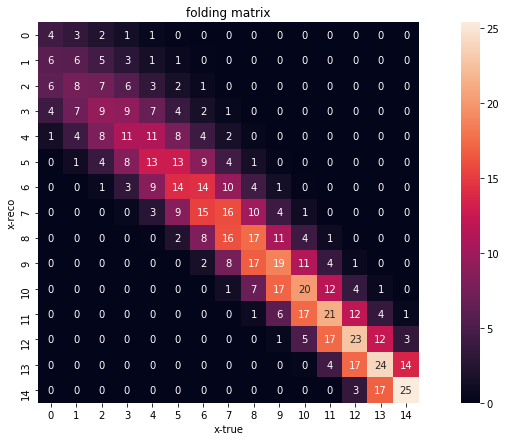

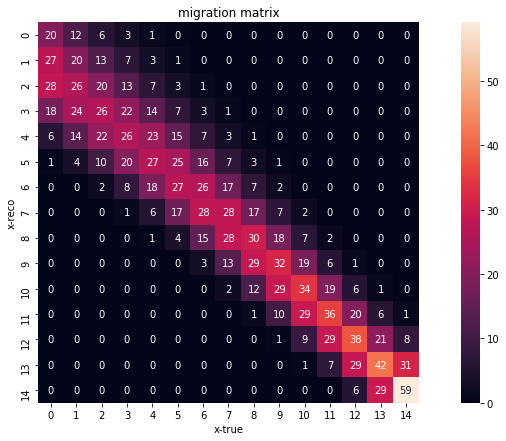

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(folding_matrix * 100, annot=True, square=True, ax=ax, fmt='.0f')
ax.set_xlabel('x-true')
ax.set_ylabel('x-reco')
ax.set_title('folding matrix')
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(migration_matrix * 100, annot=True, square=True, ax=ax, fmt='.0f')
ax.set_xlabel('x-true')
ax.set_ylabel('x-reco')
ax.set_title('migration matrix')
plt.show()

## Create workspace

In [12]:
# model with the matrix inversion
# prod_R{ Poisson[xreco_R | sum_T(folding_matrix_RT * xtrue_T)] }

ws_matrix = create_workspace(["reco_bin_%03d" % b for b in range(NBINS_RECO)],
                             ["true_bin_%03d" % b for b in range(NBINS_TRUE)],
                             nsignal_gen=ntrue * NTRUE, nexpected_bkg_cat=[0] * NBINS_RECO,
                             efficiencies=folding_matrix)

pdf_matrix = ws_matrix.obj('ModelConfig').GetPdf()
obs_matrix = ws_matrix.obj('ModelConfig').GetObservables()

INFO:root:adding observables for 15 categories
INFO:root:adding efficiencies for 15 categories and 15 processes
INFO:root:adding expected events for 15 categories and 15 processes


In [13]:
# model with the matrix inversion
# prod_R{ Poisson[xreco_R | sum_T(folding_matrix_RT * xtrue_T)] }

ws_matrix_positive = create_workspace(["reco_bin_%03d" % b for b in range(NBINS_RECO)],
                                      ["true_bin_%03d" % b for b in range(NBINS_TRUE)],
                                      nsignal_gen=ntrue * NTRUE, nexpected_bkg_cat=[0] * NBINS_RECO,
                                      efficiencies=folding_matrix)

pp = countingworkspace.utils.get_free_variables(ws_matrix_positive)
for p in countingworkspace.utils.iter_collection(pp):
    p.setMin(0)

pdf_matrix_positive = ws_matrix_positive.obj('ModelConfig').GetPdf()
obs_matrix_positive = ws_matrix_positive.obj('ModelConfig').GetObservables()

INFO:root:adding observables for 15 categories
INFO:root:adding efficiencies for 15 categories and 15 processes
INFO:root:adding expected events for 15 categories and 15 processes


In [14]:
# model with correction factors
# prod_R{ Poisson[xreco_R | C_R xtrue_R] }

ws_correction = create_workspace(["reco_bin_%03d" % b for b in range(NBINS_TRUE)],   # note this
                                 ["true_bin_%03d" % b for b in range(NBINS_TRUE)],
                                 nsignal_gen=ntrue * NTRUE, nexpected_bkg_cat=[0] * NBINS_TRUE,
                                 efficiencies=np.diag(cfactors))

pdf_correction = ws_correction.obj('ModelConfig').GetPdf()
obs_correction = ws_correction.obj('ModelConfig').GetObservables()

INFO:root:adding observables for 15 categories
INFO:root:adding efficiencies for 15 categories and 15 processes
INFO:root:adding expected events for 15 categories and 15 processes


## First use a single Asimov dataset

In [15]:
asimov_data = ROOT.RooStats.AsymptoticCalculator.GenerateAsimovData(pdf_matrix, obs_matrix)
asimov_reco = np.array([x.getVal() for x in countingworkspace.utils.iter_collection(asimov_data.get())])

### Matrix inversion (Poisson likelihood)

In [16]:
ws_matrix.loadSnapshot('initial')
fit_result_matrix = pdf_matrix.fitTo(asimov_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_matrix = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())]
ntrue_fittted_error_matrix = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())]

In [17]:
def plot_result(ntrue, nreco, nfitted, nfitted_errors=None, title=""):
    fig, ax = plt.subplots()
    ax.bar(xtrue_edges[:-1], ntrue / xtrue_widths, width=xtrue_widths, align='edge', label='true')
    if nfitted_errors is None:
        nfitted_errors = np.zeros_like(nfitted)
    ax.errorbar(xtrue_centers, nfitted / xtrue_widths, nfitted_errors / xtrue_widths, marker='o', ls='', color='k', label='unfolded')
    ax.plot(xreco_centers, nreco / xreco_widths, 'r+', label='reco')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ce52489e8>)

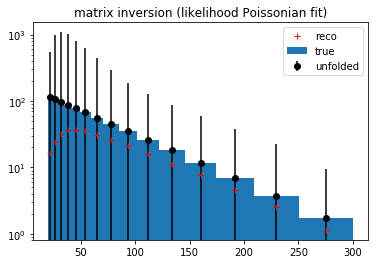

In [18]:
plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_matrix, ntrue_fittted_error_matrix, 'matrix inversion (likelihood Poissonian fit)')

Text(0.5, 1.0, 'correlation matrix matrix method Asimov')

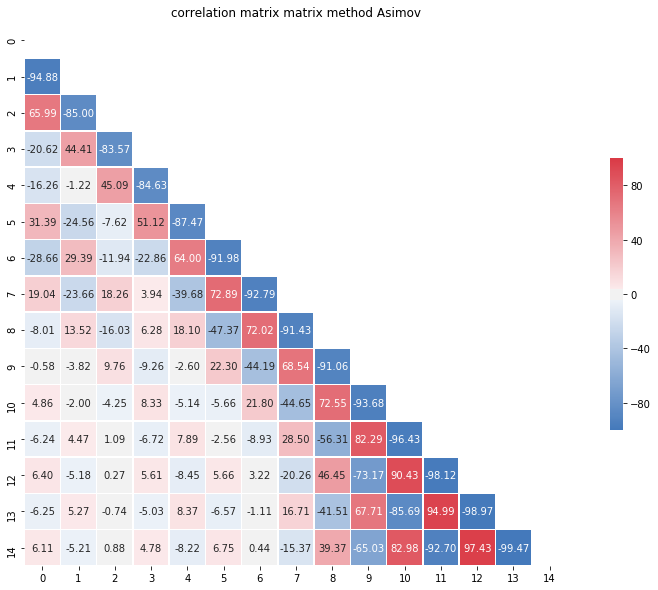

In [19]:
def root22darray(h):
    m = h.GetArray()
    m.SetSize((h.GetNbinsX() + 2) * (h.GetNbinsY() + 2))
    q = np.array(list(m)).reshape(h.GetNbinsX() + 2, h.GetNbinsY() + 2)[1:h.GetNbinsX() + 1, 1:h.GetNbinsX() + 1]
    q = np.flip(q, axis=0)
    return q

def plot_correlation(corr, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr * 100, vmin=-100, vmax=100, center=0, annot=True, fmt='.2f', ax=ax, mask=mask, square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})
    return ax

corr = fit_result_matrix.correlationHist()
corr = root22darray(corr)
ax = plot_correlation(corr)
ax.set_title('correlation matrix matrix method Asimov')

Warning in <TROOT::Append>: Replacing existing TH1: correlation_matrix (Potential memory leak).


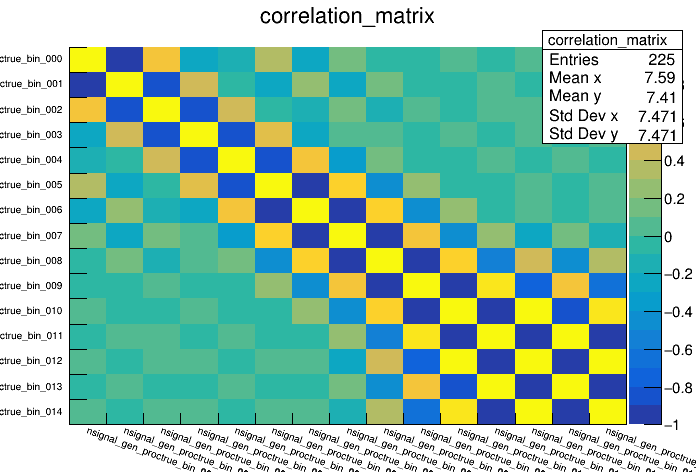

In [20]:
# same, but ugly plot with ROOT
canvas = ROOT.TCanvas()
h = fit_result_matrix.correlationHist()
h.Draw("colz")
canvas.Draw()

### Matrix inversion (Poisson likelihood) positive

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cdfbc9ef0>)

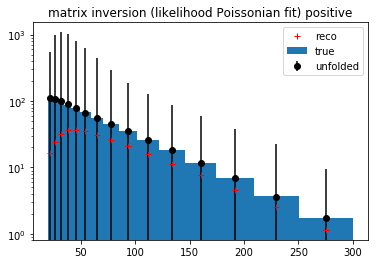

In [21]:
ws_matrix.loadSnapshot('initial')
fit_result_matrix_positive = pdf_matrix_positive.fitTo(asimov_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_matrix_positive = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())]
ntrue_fittted_error_matrix_positive = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())]

plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_matrix_positive, ntrue_fittted_error_matrix, 'matrix inversion (likelihood Poissonian fit) positive')

Text(0.5, 1.0, 'correlation matrix matrix positive method Asimov')

Warning in <TROOT::Append>: Replacing existing TH1: correlation_matrix (Potential memory leak).


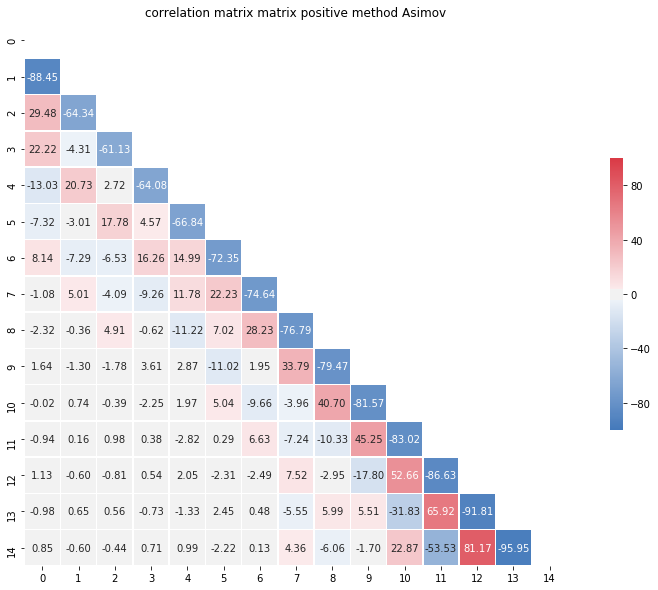

In [22]:
corr = fit_result_matrix_positive.correlationHist()
corr = root22darray(corr)
ax = plot_correlation(corr)
ax.set_title('correlation matrix matrix positive method Asimov')

### Matrix inversion (least sqaure)

Instead of a likelihood fit (using Poissonian distribution) we can use a simpler least square

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ce5033be0>)

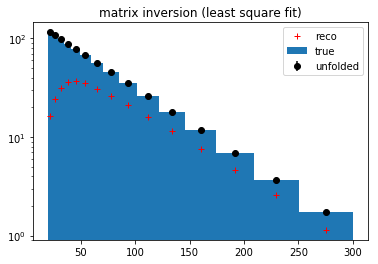

In [23]:
ntrue_fitted_chi2 = np.linalg.lstsq(folding_matrix, asimov_reco)[0]
plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_chi2, None, 'matrix inversion (least square fit)')

### Matrix inversion (least square positive)

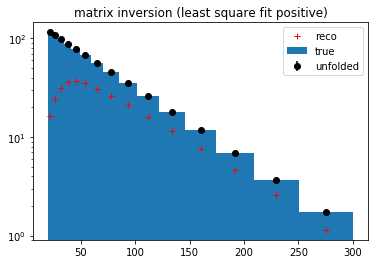

In [24]:
ntrue_fitted_chi2_positive = nnls(folding_matrix, asimov_reco)[0]
fig, ax = plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_chi2_positive, None, 'matrix inversion (least square fit positive)')

### Bin by bin (Poisson likelihood)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ce5042518>)

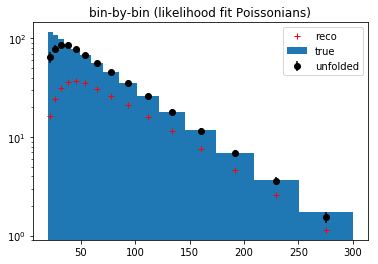

In [25]:
ws_correction.loadSnapshot('initial')
fit_result_correction = pdf_correction.fitTo(asimov_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_correction = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_correction.floatParsFinal())]
ntrue_fitted_error_correction = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_correction.floatParsFinal())]

plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_correction, ntrue_fitted_error_correction, 'bin-by-bin (likelihood fit Poissonians)')

Text(0.5, 1.0, 'correlation correction factor Asimov')

Warning in <TROOT::Append>: Replacing existing TH1: correlation_matrix (Potential memory leak).


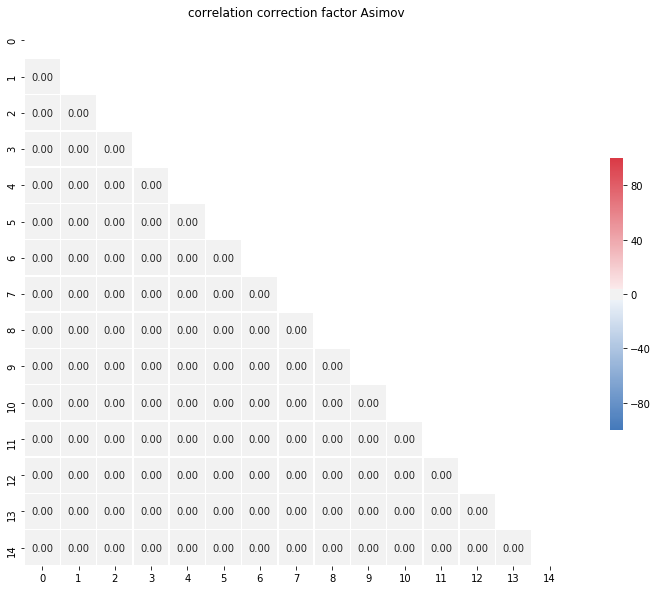

In [26]:
corr = fit_result_correction.correlationHist()
corr = root22darray(corr)
ax = plot_correlation(corr)
ax.set_title('correlation correction factor Asimov')

### Bin-by-bin (simple division)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ce8173f60>)

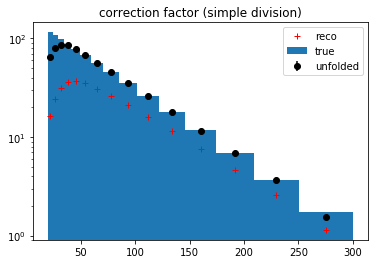

In [27]:
ntrue_fitted_binbybin = asimov_reco / cfactors
plot_result(ntrue * NTRUE, asimov_reco, ntrue_fitted_binbybin, None, 'correction factor (simple division)')

## Single toy example

In [28]:
toy_data = pdf_matrix.generate(obs_matrix, 1)
toy_reco = [x.getVal() for x in countingworkspace.utils.iter_collection(toy_data.get())]

### Matrix inversion (Poisson likelihood)

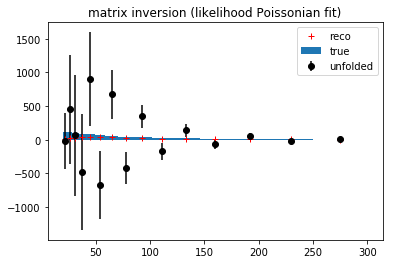

In [29]:
ws_matrix.loadSnapshot('initial')
fit_result_matrix = pdf_matrix.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_matrix = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())]
ntrue_fittted_error_matrix = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())]

fig, ax = plot_result(ntrue * NTRUE, toy_reco, ntrue_fitted_matrix, ntrue_fittted_error_matrix, 'matrix inversion (likelihood Poissonian fit)')
ax.set_yscale('linear')

### Matrix inversion (least square)

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


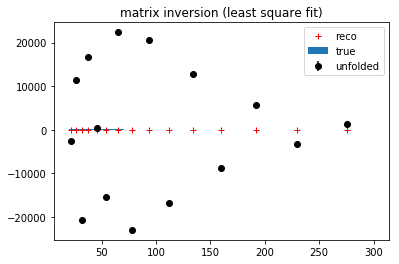

In [30]:
ntrue_fitted_chi2 = np.linalg.lstsq(folding_matrix, toy_reco)[0]
fig, ax = plot_result(ntrue * NTRUE, toy_reco, ntrue_fitted_chi2, None, 'matrix inversion (least square fit)')
ax.set_yscale('linear')

### Matrix inversion positive (Poisson likelihood)

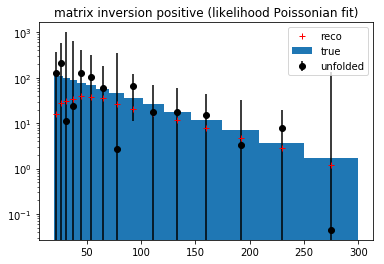

In [31]:
ws_matrix_positive.loadSnapshot('initial')
fit_result_matrix_positive = pdf_matrix_positive.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_matrix_positive = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())]
ntrue_fittted_error_matrix_positive = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())]

fig, ax = plot_result(ntrue * NTRUE, toy_reco, ntrue_fitted_matrix_positive, ntrue_fittted_error_matrix_positive, 'matrix inversion positive (likelihood Poissonian fit)')

### Matrix inversion positive (least square)

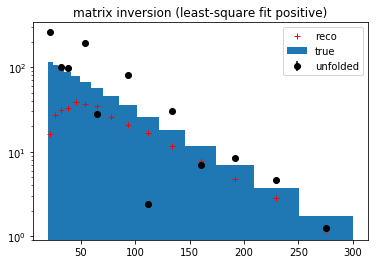

In [32]:
ntrue_fitted_chi2_positive = nnls(folding_matrix, toy_reco)[0]
fig, ax = plot_result(ntrue * NTRUE, toy_reco, ntrue_fitted_chi2_positive, None, 'matrix inversion (least-square fit positive)')

### Bin by bin (Poisson likelihood)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cd422ae10>)

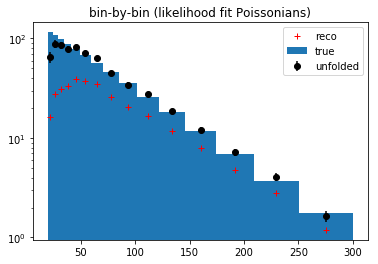

In [33]:
ws_correction.loadSnapshot('initial')
fit_result_correction = pdf_correction.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(1))
ntrue_fitted_correction = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_correction.floatParsFinal())]
ntrue_fitted_error_correction = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result_correction.floatParsFinal())]

plot_result(ntrue * NTRUE, toy_reco, ntrue_fitted_correction, ntrue_fitted_error_correction, 'bin-by-bin (likelihood fit Poissonians)')

## Toy study

In [34]:
# memory leak?

NTOYS = 2000

all_toy_reco = []
all_results_matrix = []
all_results_errors_matrix = []
all_results_matrix_positive = []
all_results_errors_matrix_positive = []
all_results_correction = []
all_results_nnls = []

for itoy in tqdm(range(NTOYS)):
    ws_matrix.loadSnapshot('initial')
    ws_matrix_positive.loadSnapshot('initial')
    ws_correction.loadSnapshot('initial')
    
    # generate toy
    toy_data = pdf_matrix.generate(obs_matrix, 1)
    toy_reco = [x.getVal() for x in countingworkspace.utils.iter_collection(toy_data.get(0))]
    all_toy_reco.append(toy_reco)

    # matrix likelihood
    fit_result_matrix = pdf_matrix.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(0))
    ntrue_fitted_matrix = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())]
    all_results_matrix.append(ntrue_fitted_matrix)
    all_results_errors_matrix.append([x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix.floatParsFinal())])
    
    # matrix likelihood
    fit_result_matrix_positive = pdf_matrix_positive.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(0))
    ntrue_fitted_matrix_positive = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())]
    all_results_matrix_positive.append(ntrue_fitted_matrix_positive)
    all_results_errors_matrix_positive.append([x.getError() for x in countingworkspace.utils.iter_collection(fit_result_matrix_positive.floatParsFinal())])
    
    # nnls
    fit_result_nnls = nnls(folding_matrix, toy_reco)[0]
    all_results_nnls.append(fit_result_nnls)
    
    # bin-by-bin likelihood
    fit_result_correction = pdf_correction.fitTo(toy_data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Hesse(0))
    all_results_correction.append([x.getVal() for x in countingworkspace.utils.iter_collection(fit_result_correction.floatParsFinal())])
     
    ROOT.SetOwnership(fit_result_matrix, True)      # ROOT doesn't like python
    ROOT.SetOwnership(fit_result_matrix_positive, True)    
    ROOT.SetOwnership(fit_result_correction, True)
    
all_results_matrix = np.array(all_results_matrix)    
all_results_matrix_positive = np.array(all_results_matrix_positive)    
all_results_correction = np.array(all_results_correction)

### Average for all the methods

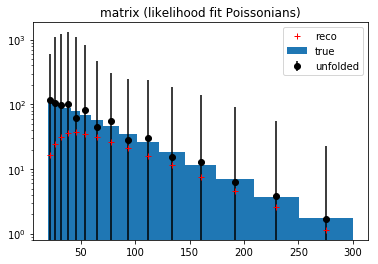

In [35]:
fig, ax = plot_result(ntrue * NTRUE,
            np.mean(all_toy_reco, axis=0),
            np.mean(all_results_matrix, axis=0), 
            np.std(all_results_matrix, axis=0),
            'matrix (likelihood fit Poissonians)')

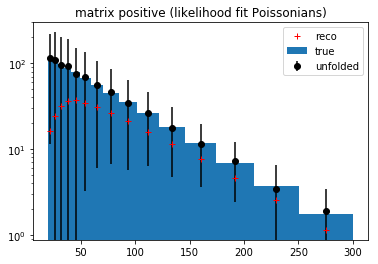

In [36]:
fig, ax = plot_result(ntrue * NTRUE,
            np.mean(all_toy_reco, axis=0),
            np.mean(all_results_matrix_positive, axis=0), 
            np.std(all_results_matrix_positive, axis=0),
            'matrix positive (likelihood fit Poissonians)')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cd3480748>)

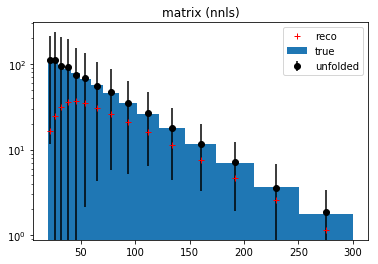

In [37]:
plot_result(ntrue * NTRUE,
            np.mean(all_toy_reco, axis=0),
            np.mean(all_results_nnls, axis=0), 
            np.std(all_results_nnls, axis=0),
            'matrix (nnls)')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4cd470ab70>)

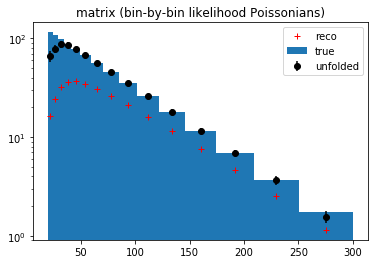

In [38]:
plot_result(ntrue * NTRUE,
            np.mean(all_toy_reco, axis=0),
            np.mean(all_results_correction, axis=0), 
            np.std(all_results_correction, axis=0),
            'matrix (bin-by-bin likelihood Poissonians)')

### All the means from the toys (bias for each bin) relative to the true values

In [39]:
toy_means_bins = [np.mean(r, axis=0) / (ntrue * NTRUE) - 1 for r in (all_results_matrix, all_results_matrix_positive, all_results_nnls, all_results_correction)]
toy_sem_bins = [stats.sem(r, axis=0) / (ntrue * NTRUE) - 1 for r in (all_results_matrix, all_results_matrix_positive, all_results_nnls, all_results_correction)]
methods = ['matrix', 'matrix pos', 'nnls', 'corr factor']
df_means_bins = pd.DataFrame(toy_means_bins, index=methods)
df_means_bins

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
matrix,0.004323,-0.022369,-0.018094,0.133529,-0.211856,0.220900,-0.218385,0.222315,-0.201108,0.178607,-0.154615,0.118337,-0.078085,0.050374,-0.031165
matrix pos,-0.005677,0.017598,-0.029134,0.056944,-0.053144,0.017790,-0.007123,0.021193,-0.018285,0.016020,-0.012474,-0.008874,0.043803,-0.077598,0.080810
nnls,-0.028890,0.043406,-0.025883,0.045886,-0.054507,0.026373,-0.014269,0.025251,-0.020482,0.019158,-0.018666,0.002925,0.025227,-0.050461,0.060570
corr factor,-0.431952,-0.265668,-0.116256,-0.033215,-0.004100,-0.002142,-0.001254,0.003350,0.000954,0.000939,0.000262,-0.002620,0.000626,-0.015372,-0.102378


Text(0, 0.5, 'unfolded-mean / true-value - 1')

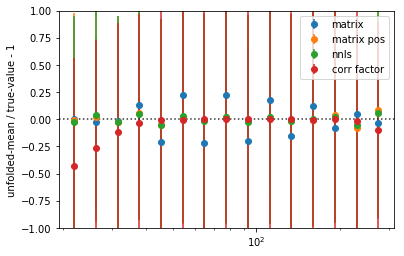

In [40]:
fig, ax = plt.subplots()
for t, te, m in zip(toy_means_bins, toy_sem_bins, methods):
    ax.errorbar(xtrue_centers, t, te, label=m, marker='o', ls='')
ax.legend(loc=0)
ax.axhline(0, color='0.2', ls=':')
ax.set_ylim(-1, 1)
ax.set_xscale('log')
ax.set_ylabel('unfolded-mean / true-value - 1')

# seems not enought toys... need to run on a cluster...

### All the rel std from the toys (bias for each bin)

In [41]:
toy_std_bins = [np.std((r / (ntrue * NTRUE)) - 1, axis=0) for r in (all_results_matrix, all_results_matrix_positive, all_results_nnls, all_results_correction)]
df_std_bins = pd.DataFrame(toy_std_bins, index=methods)
df_std_bins

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
matrix,4.282754,9.148330,11.507776,13.550694,13.242495,10.883100,7.612752,5.518938,6.097287,7.903552,9.576517,11.020732,12.496620,13.849917,11.923865
matrix pos,0.895555,1.123262,1.103618,1.130666,0.958010,0.969200,0.885464,0.872669,0.821688,0.770394,0.725417,0.684355,0.689169,0.845559,0.903636
nnls,0.870684,1.158705,1.152924,1.171968,1.011252,0.994865,0.910147,0.900259,0.832654,0.771133,0.739061,0.721801,0.745319,0.869130,0.874834
corr factor,0.070155,0.069308,0.065629,0.062873,0.057748,0.053559,0.053253,0.051559,0.053140,0.056372,0.060414,0.067833,0.079817,0.097863,0.117478


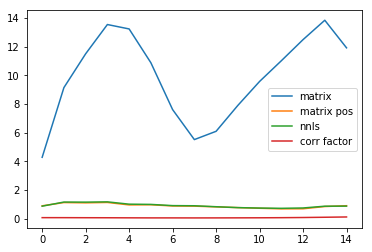

In [42]:
df_std_bins.T.plot()

## Relative residuals (fitted / true - 1)

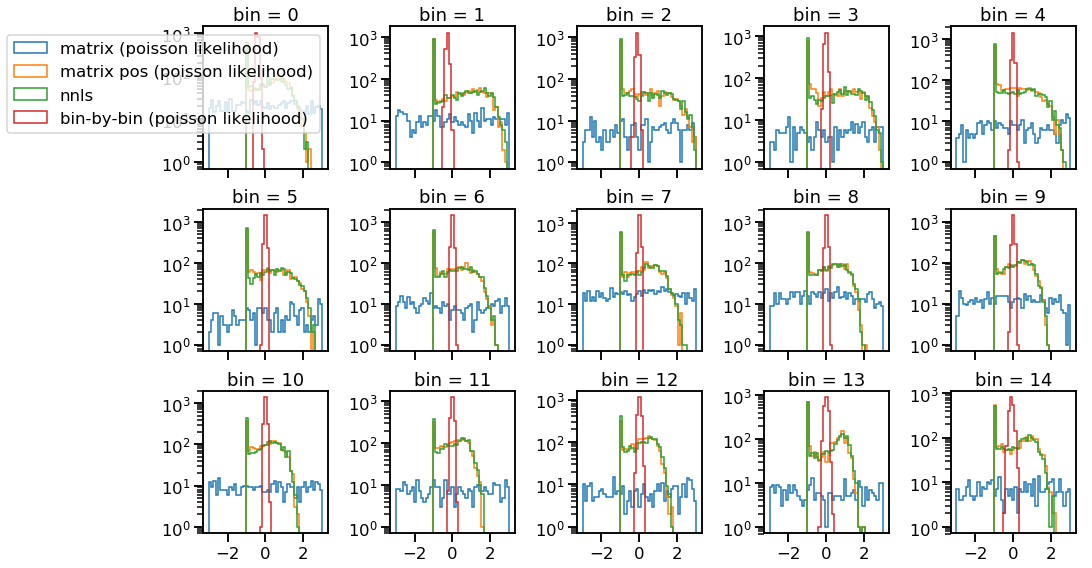

In [43]:
with sns.plotting_context("talk"):
    fig, axs = plt.subplots(int(NBINS_TRUE / 5), 5, figsize=(15, 8), sharex=True)
    for b, ax in zip(range(NBINS_TRUE), axs.flat):
        bins = np.linspace(-3, 3, 50)
        ax.hist((all_results_matrix / (ntrue * NTRUE) - 1)[:, b], label='matrix (poisson likelihood)', histtype='step', bins=bins)
        ax.hist((all_results_matrix_positive / (ntrue * NTRUE) - 1)[:, b], label='matrix pos (poisson likelihood)', histtype='step', bins=bins)
        ax.hist((all_results_nnls / (ntrue * NTRUE) - 1)[:, b], label='nnls', histtype='step', bins=bins)
        ax.hist((all_results_correction / (ntrue * NTRUE) - 1)[:, b], label='bin-by-bin (poisson likelihood)', histtype='step', bins=bins)
        ax.set_title('bin = %d' % b)
        ax.set_yscale('log')
    axs[0][0].legend()
plt.tight_layout()    

## M * fitted / reco

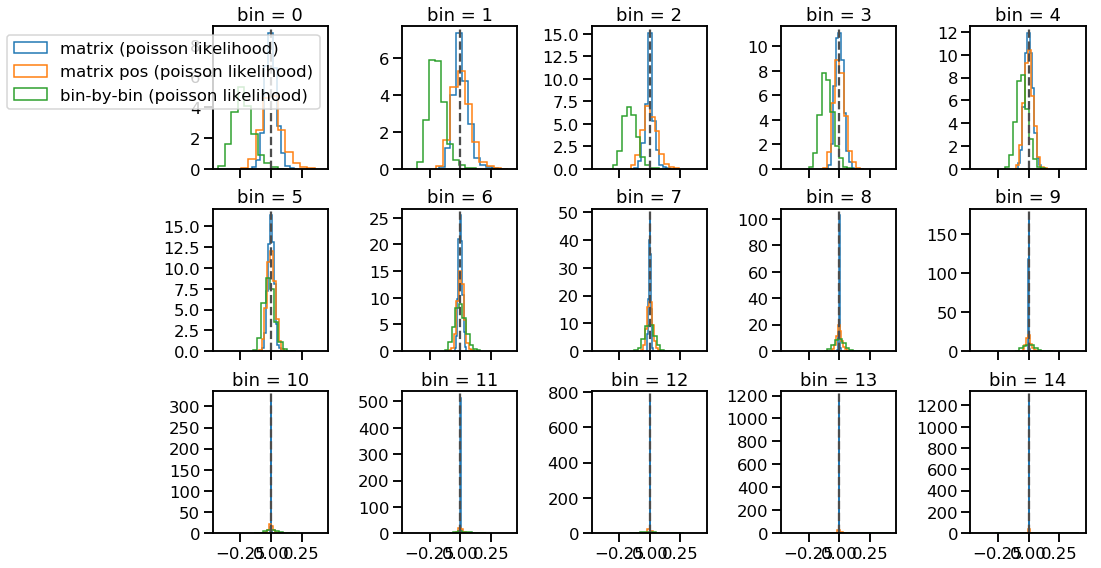

In [44]:
with sns.plotting_context("talk"):
    fig, axs = plt.subplots(int(NBINS_TRUE / 5), 5, figsize=(15, 8), sharex=True)
    for b, ax in zip(range(NBINS_TRUE), axs.flat):
        ax.hist((np.dot(folding_matrix, all_results_matrix.T).T / all_toy_reco - 1)[:, b], label='matrix (poisson likelihood)', histtype='step', density=True)
        ax.hist((np.dot(folding_matrix, all_results_matrix_positive.T).T / all_toy_reco - 1)[:, b], label='matrix pos (poisson likelihood)', histtype='step', density=True)
        ax.hist((np.dot(folding_matrix, all_results_correction.T).T / all_toy_reco - 1)[:, b], label='bin-by-bin (poisson likelihood)', histtype='step', density=True)
        ax.set_title('bin = %d' % b)
        ax.axvline(0, color='0.3', ls='--')
    axs[0][0].legend()
plt.tight_layout()

## Correlation from toys

In [45]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

cov_toys_matrix = np.cov(all_results_matrix.T)
corr_toys_matrix = correlation_from_covariance(cov_toys_matrix)

cov_toys_matrix_positive = np.cov(all_results_matrix_positive.T)
corr_toys_matrix_positive = correlation_from_covariance(cov_toys_matrix_positive)

cov_toys_correction = np.cov(all_results_correction.T)
corr_toys_correction = correlation_from_covariance(cov_toys_correction)

Text(0.5, 1.0, 'correlation matrix from toys (matrix likelihood Poisson)')

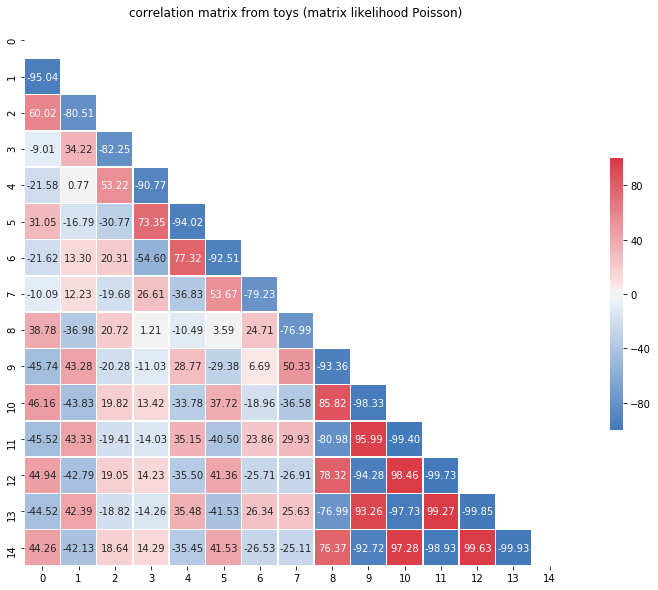

In [46]:
ax = plot_correlation(corr_toys_matrix)
ax.set_title('correlation matrix from toys (matrix likelihood Poisson)')

Text(0.5, 1.0, 'correlation matrix positive from toys (matrix likelihood Poisson)')

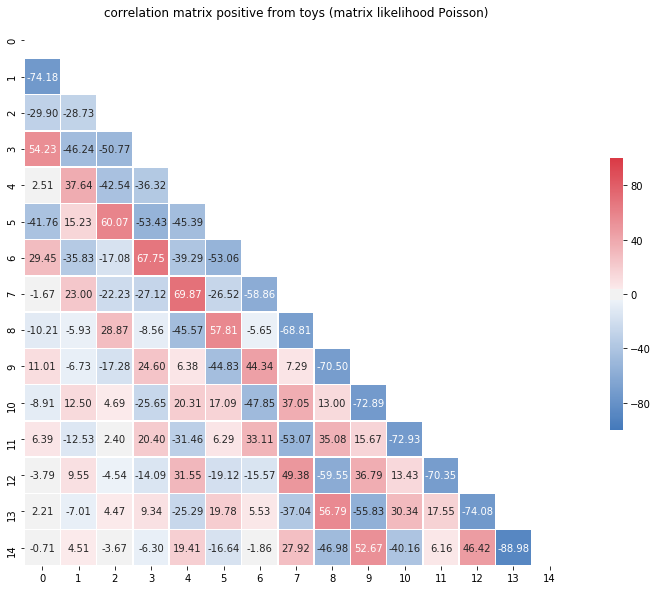

In [47]:
ax = plot_correlation(corr_toys_matrix_positive)
ax.set_title('correlation matrix positive from toys (matrix likelihood Poisson)')

Text(0.5, 1.0, 'correlation matrix from toys (bin-by-bin likelihood Poisson)')

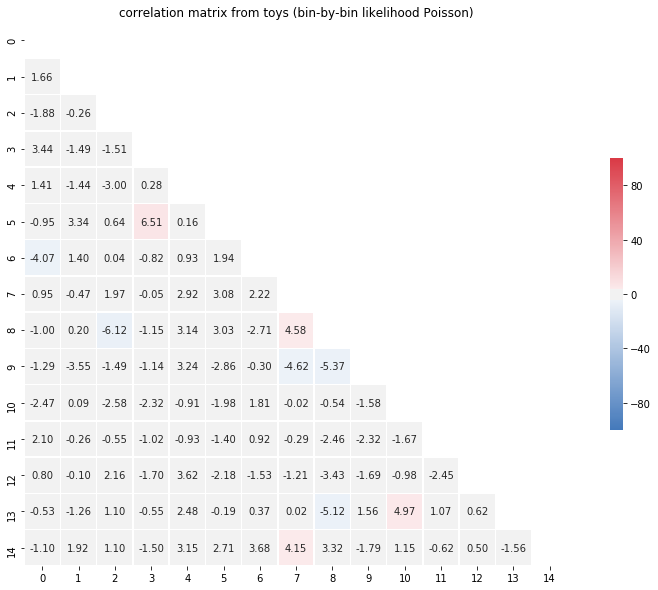

In [48]:
ax = plot_correlation(corr_toys_correction)
ax.set_title('correlation matrix from toys (bin-by-bin likelihood Poisson)')